In [2]:
# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py 
import numpy as np
from scipy.optimize import minimize
from scipy.signal import find_peaks, peak_widths
from skimage.morphology import closing,square, label, convex_hull_image
from scipy import ndimage as ndi
from tqdm import tqdm

In [3]:
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

In [4]:
#####
#Most functions are in both Test_funtions.ipynb and Segmentation.ipynb
# if functions aren't commented properly in Test_funtions.ipynb look in Segmentation.ipynb they are commented right
####

In [5]:
path_4x = '/mnt/data/MAXIBONE/Goats/tomograms/hdf5-byte/scale/4x/'

path_1x = '/mnt/data/MAXIBONE/Goats/tomograms/hdf5-byte/scale/1x/'

mask_path ='/mnt/data/MAXIBONE/Workspace/Mads/Bit_masks/'

samples = ['769c.h5','770c.h5', '771c.h5', '772.h5' ,'774.h5','775.h5','778c.h5',\
           '780c.h5','785c.h5', '788c.h5', '810c.h5','811.h5','815.h5','819.h5']

samples_1x = ['769.h5','769c.h5','770.h5', '770c.h5','771.h5', '771c.h5', '772.h5',\
              '774.h5','775.h5', '775c.h5','778.h5', '778c.h5','780c.h5', '785c.h5',\
              '788c.h5','810.h5','810c.h5','811.h5','815.h5','819.h5']

seg_path ='/mnt/data/MAXIBONE/Workspace/Mads/Concatenated_1x_samples/'
seg_path4 ='/mnt/data/MAXIBONE/Workspace/Mads/Concatenated_4x_samples/'

XX = np.linspace(1,255,254)


In [6]:
n = 0
scale = '1x'

In [7]:
# Function for quick visual representation of images
def img_show(x,n,xy =(None,None) ,title = (None,None), cmap = None, vmax = None,vmin = None, dual_view = False, colorbar=None):
    """Gives a quick view of an image, without writing too many lines"""
    """x: 2d-array to be projected; n: size of the imshow projection ; dual_view: If two images are to be shown simultaneuosly"""    
    if dual_view:
        fig,ax = plt.subplots(ncols = 2, figsize = (n,n))
        im =  ax[0].imshow(x[0])
        im2 = ax[1].imshow(x[1])
        ax[0].set_title(title[0], fontsize = 18)
        ax[1].set_title(title[1], fontsize = 18)
        ax[0].set_xlabel(xy[0], fontsize = 18)
        ax[0].set_ylabel( xy[1], fontsize = 18)
        ax[1].set_xlabel(xy[0], fontsize = 18)
        ax[1].set_ylabel( xy[1], fontsize = 18)
        if colorbar:
            fig.colorbar(im, ax = ax[0],fraction = 0.04,pad = 0.05)
            fig.colorbar(im2, ax = ax[1], fraction = 0.04,pad = 0.05)
    else:
        plt.figure(figsize = (n,n))
        plt.imshow(x,cmap = cmap, vmax = vmax, vmin = vmin)

In [8]:
# Creates indices of a circle around a center with the given radius
def circle(r,center):
    """Creates indices in a circular pattern"""
    """r: Radius of the circle pattern; center: center of the circle"""
    x, y = r*10 * [0], r*10 * [0]
    for i,theta in enumerate(np.linspace(0,2*np.pi,r*10)):
        x[i] = r * np.cos(theta)
        y[i] = r * np.sin(theta)
    return (np.array(x)+center).astype(int), (np.array(y)+center).astype(int)

#Scan sample and creates histograms for each radial layer
def rad_scan3d(data):
    rad = data.shape[1]//2
    arr = np.zeros((rad - 1, 254))
    bins = np.arange(1,256)

    for i in range(1,rad - 1):
        x,y = circle(i,rad)
        comb_circ = np.concatenate((data[:,x,y],data[:, x, -y + rad*2]))
        hist,_ = np.histogram(comb_circ, bins = bins)
        arr[i,:] += hist
    return arr

# Mask for removing all indices outside the cylinder 
def mask(data):
    Ny, Nx = data.shape
    R = Nx / 2
    xs = np.linspace(-R,R,Nx)
    ys = np.linspace(-R,R,Ny)
    rs = np.sqrt(xs[None,:]**2 + ys[:,None]**2)
    mask = rs <= R
    return mask


# Scan the sample along the y-axis, outputting an 2d array of the Distribution
# with respect to spatial placement and intensity
def xy_scan(data):
    masked = mask(data[0,:,:])
    z_list = np.zeros_like(data)
    y_list = np.zeros((data.shape[1],254))
    x_list = np.zeros((data.shape[1],254))

    for slice in range(np.min(data.shape)):
        z_list[slice] += data[slice] * masked
    for j in range(data.shape[1]):
        y_slice = z_list[:,j,:].reshape(-1)
        x_slice = z_list[:,:,j].reshape(-1)
        histogram_y,_ = np.histogram(y_slice, bins = np.arange(1,256))
        histogram_x,_ = np.histogram(x_slice, bins = np.arange(1,256))
        y_list[j,:] += histogram_y
        x_list[j,:] += histogram_x
    return y_list, x_list

# Scans sample along the z_axis
def z_scan(data):
    masked = mask(data[0,:,:])
    z_list = np.zeros((data.shape[0],254))

    for slice in range(data.shape[0]):
        z_list[slice] += np.histogram(data[slice] * masked, bins = np.arange(1,256))[0]
    return z_list

# Creates a mask for the implant and everything above it 
def implant_bitmask(data,threshold):
    implant_mask = np.zeros_like(data, dtype = bool)
    implant_mask[data > threshold] = True
    tot = np.prod(data.shape[1:])//100
    for i in range(len(implant_mask)):
        lab = ndi.label(implant_mask[i])
        test = np.where(lab[0] > 0)
        clusters = np.array([np.where(lab[0]==x)[0].size for x in range(1,5)])
        if len(test[0]) < tot:
            implant_mask[i] = False
        else:
            max_cluster = clusters.argmax() + 1
            max_indices = np.where(lab[0] == max_cluster)
            y,x = max_indices
            left =  y[x.argmin()] # max y val at min x val
            right = y[x.argmax()] # max y val at max x val
            if left >= right:
                implant_mask[i, :right+2] = True
                implant_mask[i, right:left+2, :x.min()] = True
                implant_mask[i] = ndi.binary_fill_holes(implant_mask[i])
            elif left <= right:
                implant_mask[i, :left+2] = True
                implant_mask[i, left:right+2, x.max():] = True
                implant_mask[i] = ndi.binary_fill_holes(implant_mask[i])
    return ~implant_mask



# Combines multiple masks
def mask_multiplier(tup,idx):
    if type(tup) == type((1,2,2)):
        mask = ~tup[0][idx]
        for i in range(1,len(tup)):
            mask *= ~tup[i][idx]
        return mask
    elif type(tup) == type(1) or type(tup) == type(1.0):
        return 1
    else:
        return ~tup[idx]

# Loads data and uses all above functions to create four distinct 2D-histograms w.r.t. x-, y- ,z- and radial axis
# Includes masks for removing unwanted data 
def load_2D_data(data,n, frac, masks):
    z_len  = data['voxels'].shape[0]
    y_len  = data['voxels'].shape[1]
    rad_len = y_len//2
    frag_z = z_len//n
    hist_z =   np.zeros((z_len, 254))
    hist_y =   np.zeros((y_len, 254))
    hist_x =   np.zeros((y_len, 254))
    hist_rad = np.zeros((rad_len - 1, 254))
    k = frac % (n+1)
    for i in range(k):
        indices = np.arange(frag_z * i, frag_z * (i+1),1)
        sample_frac = data['voxels'][indices]
        filt = implant_bitmask(sample_frac,100)
        sample_frac = sample_frac * filt * mask_multiplier(masks,indices)
        R = rad_scan3d(sample_frac)
        Y,X = xy_scan(sample_frac)
        Z = z_scan(sample_frac)
        hist_rad += R
        hist_y   += Y
        hist_x   += X
        hist_z[frag_z * i : frag_z * (i+1)]   += Z

        print(f'{i+1} of {n} - scanned')
    print('Data has been loaded!')

    return hist_rad, hist_y, hist_x, hist_z



In [9]:
# Saves the loaded histograms
def save_hist(hist,axis_name, sample_name, mask):
    if mask:
        string = '_masked'
        np.save(axis_name + '_hist_' + sample_name + string, hist)
    else:
        string = ''
        sn = sample_name
        np.save(axis_name + '_hist_' + sn + string, hist)

# Loads histograms of a specific sample
def load_processed_histograms_rzyx(sample,scale,mask):
    if mask ==1:
        return np.load('rad_hist_'+ sample[:-3]+'_'+ scale +'_masked.npy', allow_pickle = True ),\
    np.load('z_hist_'+ sample[:-3]+'_'+ scale +'_masked.npy', allow_pickle = True ),\
    np.load('y_hist_'+ sample[:-3]+'_'+ scale +'_masked.npy', allow_pickle = True ),\
    np.load('x_hist_'+ sample[:-3]+'_'+ scale +'_masked.npy', allow_pickle = True )
    elif mask==0:
        return np.load('rad_hist_'+ sample[:-3]+'_'+ scale +'.npy', allow_pickle = True ),\
    np.load('z_hist_'+ sample[:-3]+'_'+ scale +'.npy', allow_pickle = True ),\
    np.load('y_hist_'+ sample[:-3]+'_'+ scale +'.npy', allow_pickle = True ),\
    np.load('x_hist_'+ sample[:-3]+'_'+ scale +'.npy', allow_pickle = True )
    elif mask ==2:
        return np.load('rad_hist_'+ sample[:-3]+'_'+ scale +'_double_masked.npy', allow_pickle = True ),\
    np.load('z_hist_'+ sample[:-3]+'_'+ scale +'_double_masked.npy', allow_pickle = True ),\
    np.load('y_hist_'+ sample[:-3]+'_'+ scale +'_double_masked.npy', allow_pickle = True ),\
    np.load('x_hist_'+ sample[:-3]+'_'+ scale +'_double_masked.npy', allow_pickle = True )

In [10]:
### Generel functions for fitting and describing data

# Baseline distribution for all fits of histograms
def power(vars,xs):
    n = vars.size//4
    abcd = np.reshape(vars,(4 ,n)).T
    A, B, C, D = abcd[:,0,np.newaxis]**2, abcd[:,1,np.newaxis]**2, abcd[:,2,np.newaxis], abcd[:,3,np.newaxis]**2
    X          = xs[np.newaxis,:]
    d = 1 + np.sqrt(1 / (1 + D)) # Interval between 1 and 2
    return np.sqrt(A) * np.exp(- np.sqrt(B) * np.power(np.abs(X - C), d ))

# Penalty function to ensure fit doesn't go outside curves, a.e. so the distribution doesn't describe something there isn't there
def neg(f):
    neg = (np.abs(f) - f)/2
    return neg

# The fucntion the minimizer evaluates the variables for the power function
def error_power(vars,x_data,f_exact, overshoot_penalty):
    fopt = np.sum(power(vars,x_data), axis = 0)
    E    = np.sum((f_exact - fopt)**2)  + overshoot_penalty * np.sum(neg(f_exact - fopt)**2)
    return E


# Reverts the histogram to individual data points to find intial spread for the distributions
def sigma_spread(x,y,peaks):
    left = np.floor(peaks[1]['left_ips']).astype(int)
    right = np.ceil(peaks[1]['right_ips']).astype(int)
    ips = np.vstack((left,right)).T
    ips_expanded = [np.arange(i.min(),i.max()+1, 1) for i in ips]
    values = [np.repeat(x[j],y[j].astype(int)) for j in ips_expanded]
    spread = np.array([np.std(values[k]) for k in range(len(values))])
    return 1 / (2*spread)**2

# Normalises the histogram w.r.t. maximum value
def normalise(x):
    if (np.max(x)-np.min(x)) == 0:
        return np.zeros_like(x)
    else:
        return(x-np.min(x))/(np.max(x)-np.min(x))

In [11]:
# Upgraded minimizer
# Creates the bounds for mimimizer to limit parameter range
def bounds(x):
    n = x.size//4
    A = np.array([(i/10,i) for i in x[:n]])
    B = np.array([(-100,100) for i in range(n)])
    C = np.array([(i-1,i+1) for i in x[2*n:3*n]])
    D = np.array([(0,1000) for i in range(n)])
    return np.concatenate((A,B,C,D))

# Finds the most prominent peaks of the histogram and outputs peaks value i.e. placement and widths 
def peak_info_seg(data):
    initial_peaks = find_peaks(data)[0]

    peak_vals = data[initial_peaks].astype(int)# values of the "peaks" 
    PW,PH,l_ips,r_ips = peak_widths(data, initial_peaks)
    MH = np.mean(PH)/3
    final = np.array([x for x in range(len(PW)) if PH[x] >= MH]).astype(int)
    dict  = {'left_ips': l_ips[final],'right_ips': r_ips[final]}
    return initial_peaks[final], dict

# Takes the output from the peak_info_seg and turns them into the initial guess for fitting parameters
def initial_trial6(xs,data, method = 'power'):

    init_peaks = peak_info_seg(data)

    peak_idx = init_peaks[0]

    n = len(peak_idx) # number of peaks
    A = data[peak_idx] # Amplitude of the distribution
    C = xs[peak_idx] # Mean of distribution
    B = sigma_spread(xs,data,init_peaks) # the spread of each distribution
    if method == 'gauss':
        vars = np.concatenate((A,B,C))
    elif method == 'power':
        D = np.ones(n)*0.5
        vars = np.concatenate((A,B,C,D))
    return vars


# Takes the initial parameters and minimizes them and outputs fittet parameters and final distribution
def minimizer_mask(xs, data, penalty):
    vars = initial_trial6(xs, data, 'power')
    if len(vars) < 1:
        return np.zeros(1), np.zeros(len(xs))
    else:
        bnds = bounds(vars)
        fit = minimize(error_power,vars, args = (xs, data, penalty), bounds = bnds)
        return fit.x, power(fit.x, xs)


In [12]:
def upscale_1d(x):
    X  = np.repeat(x,4,axis = 1)
    return np.pad(X,[(0,0), (0, 1), (0, 0)], mode='constant')

def upscale_2d(x):
    X  = np.repeat(x,4,axis = 1)
    X  = np.repeat(X,4,axis = 2)
    X  = np.repeat(X,4,axis = 0)
    return np.pad(X, [(0,0), (0, 1), (0, 1)], mode='constant')

# Returns the indices of interest within a certain radial interval
def mask_seg3Deux(data,r1,r2):
    
    R = data.shape[1]/2
    l = np.zeros(data.shape[0])
    xy = data.shape[1]
    c = np.linspace(-R,R,xy)
    rs = np.sqrt(c[None,:]**2 + c[:,None]**2)
    outer_mask = rs <= r1
    inner_mask = rs >= r2
    if len(data.shape) ==3:
        mask = outer_mask == inner_mask
        mask = l[:,None,None] + mask[None,:,:]
        return np.where(mask==True)
    else:
        mask = outer_mask == inner_mask
        return np.where(mask==True)

In [13]:
def create_radmask(data,rmin):
    """Creates a mask for each layer in the radial transformation"""
    """data: CT-data; rmin: number of layers from 0 to rmin acting as 'first' layer"""
    inner_layer = mask_seg3Deux(data,rmin,0)
    remaining_layers = np.array([mask_seg3Deux(data,r,r-1) for r in range(rmin,(data.shape[1]//2))])
    mask = [inner_layer]
    for i in range(len(remaining_layers)):
        mask.append(remaining_layers[i])
    return np.array(mask)

In [14]:
def create_h5py_files(shape, axis, scale, sample, n_class):
    """create h5py files to compress new segmented CT's"""
    output_files = [h5py.File(axis +'_segmentation_' + scale + '_' + sample[:-3] +'_'+ 'Class'+ str(x+1) + '.h5','w') for x in range(n_class)]
    for i in range(n_class):
        output_files[i].create_dataset("mask_voxels", shape, dtype=np.float, compression="lzf")
    output_voxels = [output_files[v]['mask_voxels'] for v in range(n_class)]
    return output_voxels, output_files

In [15]:
def rad_segmentation4(data, fit, m_ind, rmin):
    """Segments CT with given probability distributions, with the radial transformation"""
    """fit: The distribution to segment with; m_ind: mask indices; rmin: outer limit for the first chunk of layers """
    arrs = [np.zeros_like(data).astype(float) for i in range(len(fit))]
    for i in range(len(fit[0])-chunk):
        if i == 0:
            r1 = rmin
            hist0 = fit[:][:r1].sum(axis=(0,1))
            _,fit0 = minimizer_mask(XX,hist0,5)
            for j in range(len(fit0)):
                arrs[j][:,m_ind[i,0],m_ind[i,1]] += normalise(fit0[j,data[:,m_ind[i,0],m_ind[i,1]]])
        else:
            for j in range(len(fit)):
                arrs[j][:,m_ind[i,0],m_ind[i,1]] += normalise(fit[j][i,data[:,m_ind[i,0],m_ind[i,1]]])
    return arrs

In [16]:
def zyx_test_segmentation(data, fit, zyx, depth):
    """Segmentation function for Z, Y and X"""
    arrs = []
    
    if zyx == 0: # meaning Z-segmentation
        for j in range(len(fit)):
            arrs.append(np.array([normalise(fit[j][val+depth, data[val,:,:]]) for val in range(data.shape[zyx])]))
                
    elif zyx == 1: # Y-Segmentation
        for j in range(len(fit)):
            arrs.append(np.array([normalise(fit[j][val, data[:,val,:]]) for val in range(data.shape[zyx])]))
                
    elif zyx == 2: # X-Segmentation
        for j in range(len(fit)):
            arrs.append(np.array([normalise(fit[j][val, data[:,:,val]]) for val in range(data.shape[zyx])]))
                
    return arrs

In [17]:
def choose_axis(dim):
    """number of dim choose the string to name the segmentation"""
    if dim == 0:
        axis = 'z'
    elif dim ==1:
        axis = 'y'
    elif dim ==2:
        axis = 'x'
    return axis

In [18]:
def final_zyx_segmentation(sample, scale, fit, zyx, chunk_size):
    """Segments CT with given probability distributions"""
    """Creates partially closed bone bitmask with binary_fill_holes"""
    """sample: .h5 file of the CT; scale: the scale of the data i.e 1x, 2x etc"""
    """fit: The distribution to segment with; chunk_size: size of CT chunks used for each iteration """
    """zyx: 0, 1 or 2 relating to Z-,Y- or X-segmentation repsectively """
    tomogram     = h5py.File(seg_path + scale + '_' + sample[:-3]+'_concat.h5', 'r')
    implant_mask = h5py.File(mask_path + 'Implant-bitmask_'+ scale + '_' + sample, 'r')
    print('Files has been loaded')
    n = len(fit)# number of class
    shape = tomogram['voxels'].shape
    axis = choose_axis(zyx)
    output, files = create_h5py_files(shape, axis, scale, sample, n) # Creates h5py files
    print('H5py-files are ready to be written')
    if zyx ==0:
        for i in tqdm(range(0, shape[0], chunk_size)): #shape[zyx]
            ni = min(chunk_size, shape[0]-i) #zyx determines which axis to be iterated through
            Layer = tomogram['voxels'][i:i+ni]
            masked_sample = Layer * implant_mask['mask_voxels'][i:i+ni]
            segments = zyx_test_segmentation(masked_sample, fit, zyx, i)
            for seg in range(n):
                output[seg][i:i+ni] = segments[seg]
    
    elif zyx == 1:
        for i in tqdm(range(0, shape[0], chunk_size)): #shape[zyx]
            ni = min(chunk_size, shape[0]-i) #zyx determines which axis to be iterated through
            Layer = tomogram['voxels'][i:i+ni]
            masked_sample = Layer * implant_mask['mask_voxels'][i:i+ni]
            segments = zyx_test_segmentation(masked_sample, fit, zyx, 0)
            for seg in range(n):
                output[seg][i:i+ni] = np.moveaxis(segments[seg],0,-2)
                
    elif zyx == 2:
        for i in tqdm(range(0, shape[0], chunk_size)): #shape[zyx]
            ni = min(chunk_size, shape[0]-i) #zyx determines which axis to be iterated through
            Layer = tomogram['voxels'][i:i+ni]
            masked_sample = Layer * implant_mask['mask_voxels'][i:i+ni]
            segments = zyx_test_segmentation(masked_sample, fit, zyx, 0)
            for seg in range(n):
                output[seg][i:i+ni] = np.moveaxis(segments[seg],0,-1)    

    for k in range(n): # closes the generate files again
        files[k].close()
    tomogram.close()
    implant_mask.close()
    print('Files has been closed')
    print(axis.upper() + '-segmentation is done')

In [19]:
def final_rad_segmentation(sample, scale, fit, rmin, chunk_size):
    """Segments CT wrt to radial fitted distributions"""
    """sample: .h5 file of the CT; scale: the scale of the data i.e 1x, 2x etc; rmin: outer limit for the first chunk of layers"""
    """fit: The distribution to segment with; chunk_size: size of CT chunks used for each iteration """
    tomogram     = h5py.File(seg_path + scale + '_' + sample[:-3]+'_concat.h5', 'r')
    implant_mask = h5py.File(mask_path + 'Implant-bitmask_'+ scale + '_' + sample, 'r')
    print('Files has been loaded')
    mask_indices = create_radmask(tomogram['voxels'][1000], rmin)
    print('Mask\'s made')
    n = len(fit)# number of clasas
    shape = tomogram['voxels'].shape
    
    output, files = create_h5py_files(shape,'rad', scale, sample, n) # Creates h5py files
    print('H5py-files are ready to be written')
    for i in tqdm(range(0, shape[0], chunk_size)):
        ni = min(chunk_size, shape[0]-i)
        Layer = tomogram['voxels'][i:i+ni]
        masked_sample = Layer * implant_mask['mask_voxels'][i:i+ni]
        segments = rad_segmentation4(masked_sample, fit, mask_indices, rmin)
        for seg in range(n):
            output[seg][i:i+ni] = segments[seg]

    for k in range(n): # closes the generate files again
        files[k].close()
    tomogram.close()
    implant_mask.close()
    print('Files has been closed')
    print('Radial-segmentation is done')

In [20]:
def mean_print(m1,m2,zyx):
    """print mean values for a given axis"""
    if zyx == 0:
        mean1 = m1[0][m1[0]>0].mean()
        mean2 = m2[0][m2[0]>0].mean()
    elif zyx == 1:
        mean1 = m1[:,0][m1[:,0]>0].mean()
        mean2 = m2[:,0][m2[:,0]>0].mean()
    elif zyx == 2:
        mean1 = m1[:,:,0][m1[:,:,0]>0].mean()
        mean2 = m2[:,:,0][m2[:,:,0]>0].mean()
    return mean1, mean2

In [21]:
def bone_mask_fullclose(sample, scale, z_fit, chunk_size): 
    """Creates fully closed bone bitmask with convex_hull_image"""
    """sample: .h5 file of the CT; scale: the scale of the data i.e 1x, 2x etc"""
    """z_fit: The distribution to segment with; chunk_size: size of CT chunks used for each iteration """
    tomogram     = h5py.File(seg_path + scale + '_' + sample[:-3]+'_concat.h5', 'r')
    implant_mask = h5py.File(mask_path + 'Implant-bitmask_'+ scale + '_' + sample, 'r')
    fit = z_fit.reshape(1,z_fit.shape[0],z_fit.shape[1])
    

    shape = implant_mask['mask_voxels'].shape
    print(shape[0])
    print(tomogram['voxels'].shape[0])
    print(fit.shape[1])
    
    
    bone_file = h5py.File('Bone-bitmask2_' + scale + '_' + sample,'w')
    bone_file.create_dataset("mask_voxels", shape, dtype=np.bool, compression="lzf")
    output_voxels = bone_file['mask_voxels']

    print('H5py-files are ready to be written')
    
    for i in tqdm(range(0, shape[0], chunk_size)): #shape[zyx]
        ni = min(chunk_size, shape[0]-i) #zyx determines which axis to be iterated through
        Layer = tomogram['voxels'][i:i+ni]
        masked_sample = Layer * implant_mask['mask_voxels'][i:i+ni]
        segments = zyx_test_segmentation(masked_sample, fit, 0, i)
        segments = np.array([convex_hull_image(segments[0][f]) for f in range(ni)])
        output_voxels[i:i+ni] = segments
    
    
    bone_file.close()
    tomogram.close()
    implant_mask.close()
    print('Bone-mask is ready to be used')

In [22]:
def create_h5py_files(shape, axis, scale, sample, n_class):
    """create h5py files to compress new segmented CT's"""
    """axis:Z,Y,X or Radial; scale:1x,2x,4x... ; sample: .h5 CT-sample name; n_class: number of classes"""
    output_files = [h5py.File(axis +'_segmentation_' + scale + '_' + sample[:-3] +'_'+ 'Class'+ str(x+1) + '.h5','w') for x in range(n_class)]
    for i in range(n_class):
        output_files[i].create_dataset("mask_voxels", shape, dtype=np.float, compression="lzf")
    output_voxels = [output_files[v]['mask_voxels'] for v in range(n_class)]
    return output_voxels, output_files

In [23]:
def div0(a,b):
    """Allows dividing with zeros to avoid errors in areas that have been masked out"""
    """a: arr1 numerator b: arr2 demominator"""
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        c = np.true_divide(a,b)
        c [~np.isfinite(c)] = 0
    return c

In [24]:
def bone_density(rad_bone,rad_cavi,z_bone,z_cavi,shape):
    """Calculates the density of bone in each layer of Z of a sample"""
    sample_shape = shape
    print(f'Shape is {sample_shape}')
    bone_dens = np.zeros(sample_shape[0])
    print(f'bone_dens length is {len(bone_dens)}')
    for i in tqdm(range(0,sample_shape[0],100)):
        ni = min(100,sample_shape[0]-i)
        rad_b = rad_bone['mask_voxels'][i:i+ni]
        rad_c = rad_cavi['mask_voxels'][i:i+ni]
        z_b = z_bone['mask_voxels'][i:i+ni]
        z_c = z_cavi['mask_voxels'][i:i+ni]
        denom = rad_c + rad_b + z_b + z_c
        bone = rad_b + z_b
        BI = div0(bone, denom)
        bone_voxels = (BI>0.5).astype(int)
        bone_dens[i:i+ni] += bone_voxels.sum(axis =(1,2))
    return bone_dens

In [26]:
vs = [0, 2, 4, 6, 10, 13, 15, 17]

In [27]:
test = h5py.File(seg_path + '1x' + '_' + samples[0][:-3]+ '_concat.h5','r')
imps = h5py.File(mask_path + 'Implant-bitmask_1x_'+ samples_1x[vs[0]],'r')
bobs = h5py.File(mask_path + 'Bone-bitmask2_1x_'+samples_1x[vs[0]],'r')
bobs2 = h5py.File(mask_path + 'Bone-bitmask2_1x_770.h5','r')
imps2 = h5py.File(mask_path + 'Implant-bitmask_1x_770.h5','r')
res = h5py.File(mask_path + 'Resin-bitmask_1x_770c.h5','r')

In [ ]:

#mangler kun den sidste # dope
"""
for i in vs[7:]:
    samp = samples_1x[i]
    print(samp)
    real_sample = h5py.File(seg_path + f'1x_{samp[:-3]}_concat.h5','r')
    test_rad  = h5py.File('rad_segmentation_1x_{sample}_Bone.h5'.format(sample = samp[:-3]),'r')
    test_rad2 = h5py.File('rad_segmentation_1x_{sample}_Cavity.h5'.format(sample = samp[:-3]),'r')
    test_z  =   h5py.File(  'z_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')
    test_z2 =   h5py.File(  'z_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')

    shap = test_rad['mask_voxels'].shape


    dane = bone_density(test_rad, test_rad2,test_z,test_z2,shap)

    np.save(f'Bone_density_{samp}',dane)
    plt.figure(figsize = (12,8))
    plt.scatter(np.arange(len(dane)),dane)
    plt.plot(dane)
    plt.yscale('log')
    plt.show()
"""

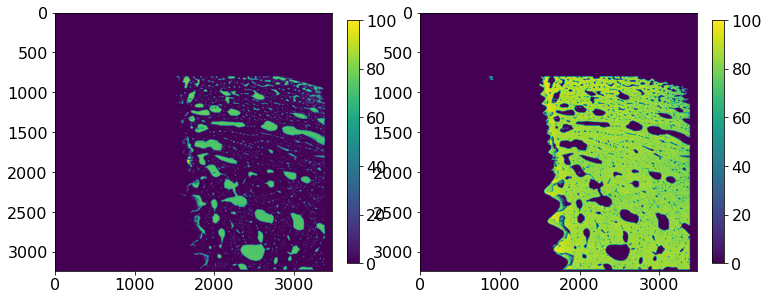

In [30]:
Dane = h5py.File('rad_correction_segmentation_1x_769_Class1.h5','r')
Dane2 = h5py.File('rad_correction_segmentation_1x_769_Class2.h5','r')
img_show((Dane['mask_voxels'][:,:,1200],Dane2['mask_voxels'][:,:,1200]),12, \
         dual_view = True, colorbar = True)

In [37]:
æ = 1500
æx = 5
rs = real_sample['voxels'][æ:æ+æx]
w1,w2 = test_rad['mask_voxels'][æ:æ+æx],test_z2['mask_voxels'][æ:æ+æx]
                #test_y['mask_voxels'][:,:,æ:æ+æx],test_x2['mask_voxels'][:,:,æ:æ+æx]
v1,v2 = test_rad2['mask_voxels'][æ:æ+æx],test_z['mask_voxels'][æ:æ+æx]
                #test_y2['mask_voxels'][:,:,æ:æ+æx],test_x['mask_voxels'][:,:,æ:æ+æx]

In [ ]:
comb = w2 + v2 + w1 + v1
meh = div0((w2+v1),comb)
meh2 = div0((v2+w1),comb)
img_show((w2[0], w1[0]),20, dual_view = True, colorbar = True, xy = ('[X]','[Y]'))

In [ ]:
dane = meh*imps['mask_voxels'][æ:æ + æx]*bobs['mask_voxels'][æ:æ + æx]
dane2 = meh2*imps['mask_voxels'][æ:æ + æx]*bobs['mask_voxels'][æ:æ + æx]
masked_rs = np.zeros_like(rs)
masked_rs[dane>0.1] = 1

In [ ]:
img_show(((rs*masked_rs)[4][2500:2700,1500:1600],rs[4][2500:2700,1500:1600]),20, dual_view = True, colorbar = True)
img_show((meh[0],meh2[0]), 12, dual_view = True

(70.0, 100.0)

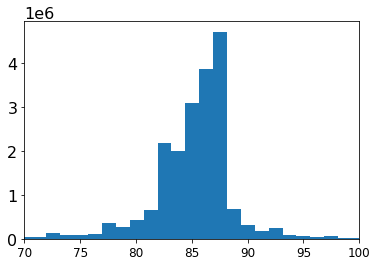

In [196]:
plt.hist((rs[0]*masked_rs).reshape(-1), bins = 200, range = (1,250));
plt.xlim(70,100) 
#plt.hist(mask.astype(int).reshape(-1), bins = 200);

In [130]:
fy = h5py.File(mask_path +'Bone-bitmask_1x_771.h5','r')
fy2 = h5py.File(mask_path +'Bone-bitmask2_1x_771.h5','r')

In [131]:
å = 2100
impi = h5py.File(mask_path + 'Implant-bitmask_1x_'+ samples_1x[vs[2]],'r')
dub = fy['mask_voxels'][å]
dub2 = fy2['mask_voxels'][å]*impi['mask_voxels'][1000]
img_show((dub,dub2),20, dual_view=True)
img_show(~(dub.astype(int) - dub2.astype(int)),12)

X-Slice


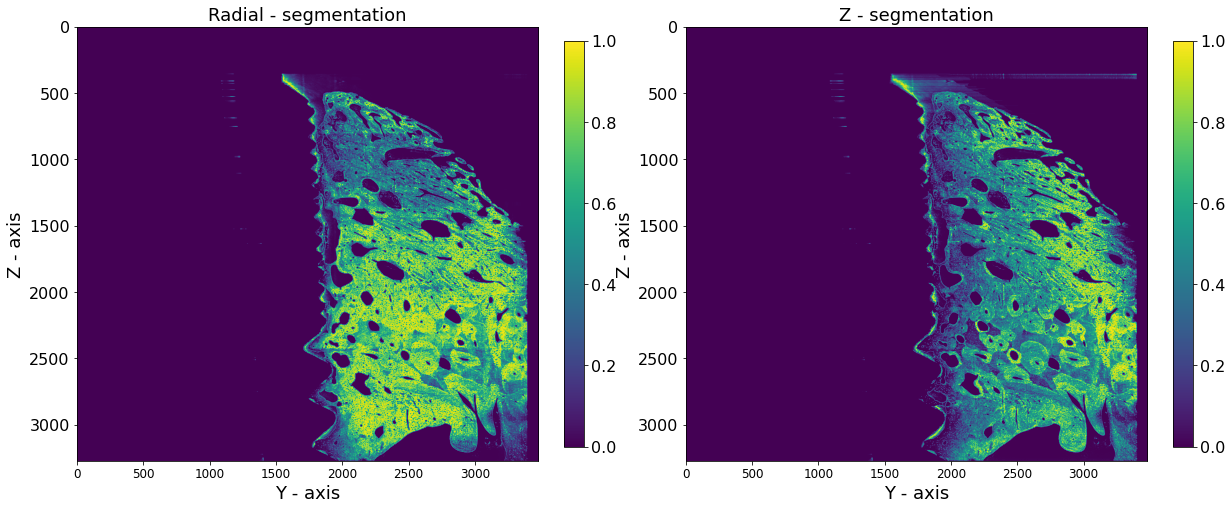

In [143]:
æ = 300*4
img_show((test_rad2['mask_voxels'][:,:,æ],test_z2['mask_voxels'][:,:,æ])\
         ,20,xy = ('Y - axis','Z - axis'), title =('Radial - segmentation','Z - segmentation'),\
         colorbar = True, dual_view = True)
print('X-Slice')

X-Slice


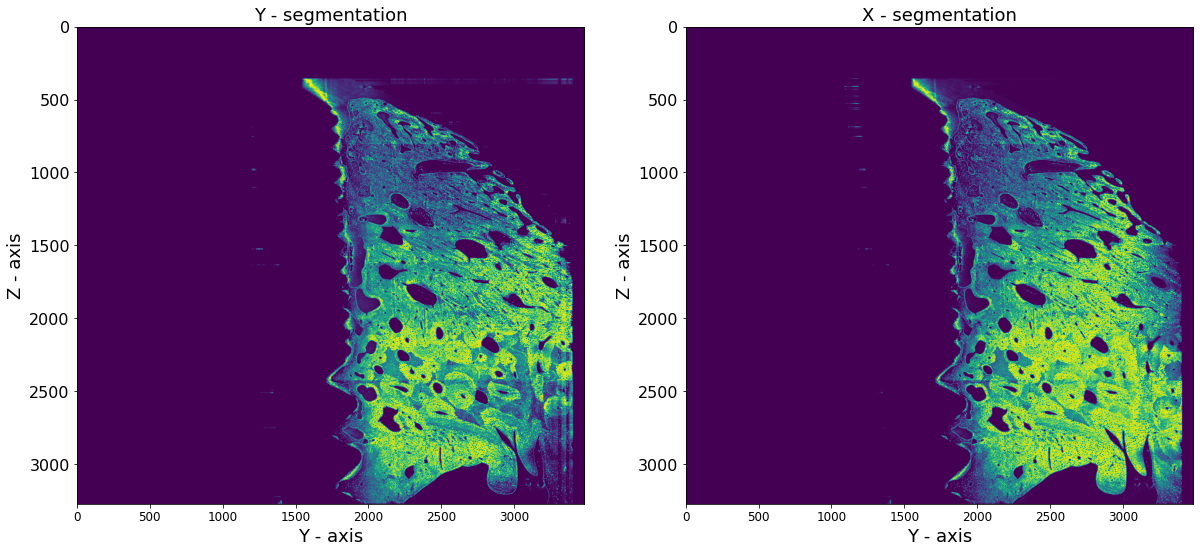

In [144]:
img_show((test_y2['mask_voxels'][:,:,æ], test_x2['mask_voxels'][:,:,æ]),\
         20,xy = ('Y - axis','Z - axis'),title =('Y - segmentation','X - segmentation') ,dual_view = True)
print('X-Slice')

Y-Slice


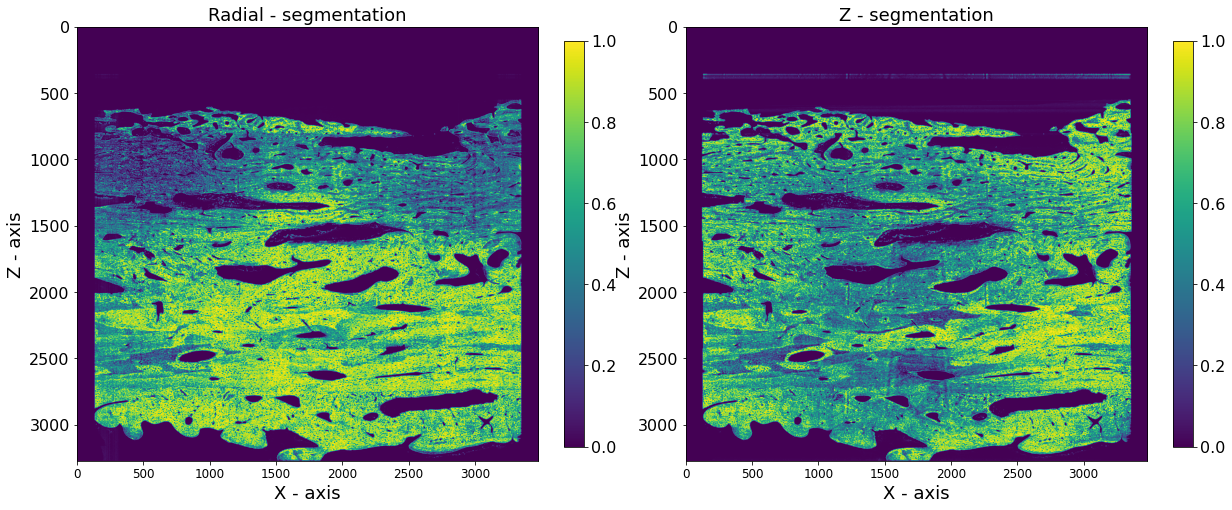

In [31]:
ø = 600*4
img_show((test_rad2['mask_voxels'][:,ø],test_z2['mask_voxels'][:,ø]),\
         20, xy = ('X - axis','Z - axis'), colorbar = True, \
         title =('Radial - segmentation','Z - segmentation'),dual_view = True)
print('Y-Slice')

Y-slice


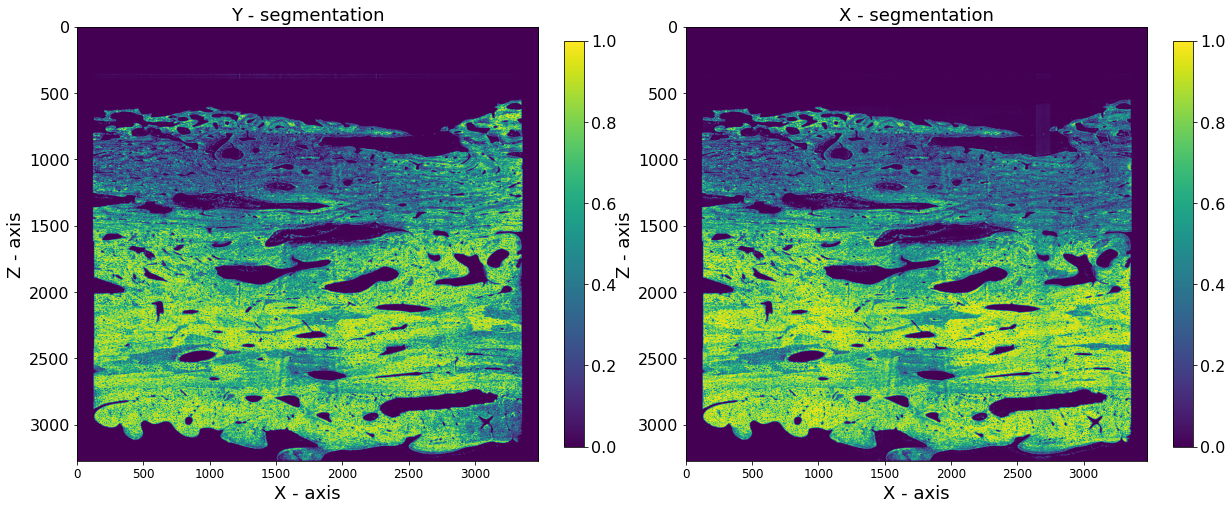

In [33]:
img_show((test_y2['mask_voxels'][:,ø],test_x2['mask_voxels'][:,ø]),\
         20, xy = ('X - axis','Z - axis'), colorbar = True,\
         title =('Y - segmentation','X - segmentation'), dual_view = True)
print('Y-slice')

Z-Slice


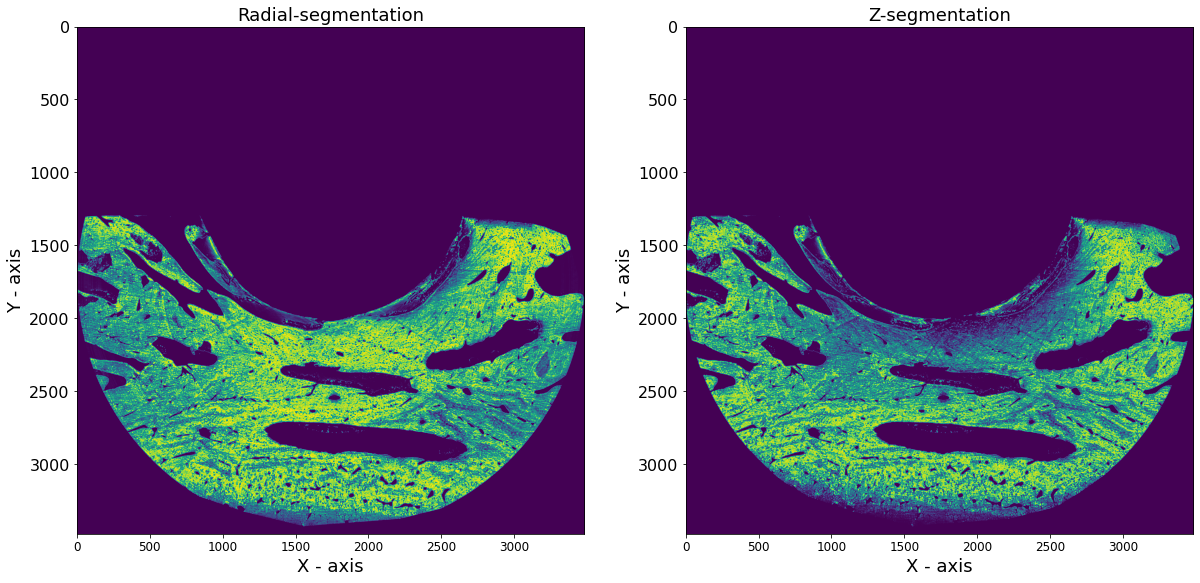

In [147]:
u = 400*4
img_show((test_rad2['mask_voxels'][u],test_z2['mask_voxels'][u]),\
         20,xy = ('X - axis','Y - axis'),title =('Radial-segmentation','Z-segmentation'),dual_view = True)
print('Z-Slice')

Z-Slice


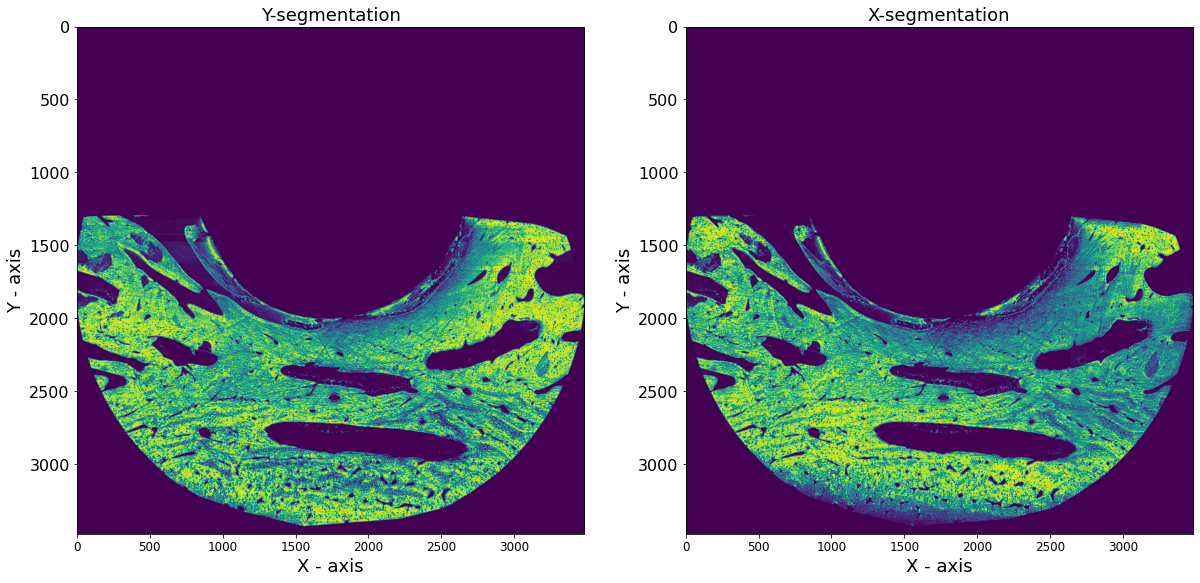

In [148]:
img_show((test_y2['mask_voxels'][u],test_x2['mask_voxels'][u]),\
         20,xy = ('X - axis','Y - axis') ,title =('Y-segmentation','X-segmentation'),dual_view = True)
print('Z-Slice')

In [46]:
"""
shape = test_z2['mask_voxels'].shape
n = 2
output, files = create_h5py_files(shape, 'rad_correction', '1x', samples_1x[vs[0]], n) # Creates h5py files
chunk_size = 50
for i in tqdm(range(0, shape[0], chunk_size)): #shape[zyx]
    ni = min(chunk_size, shape[0]-i) #zyx determines which axis to be iterated through

    rs   = real_sample['voxels'][i:i+ni]
    bone = dub['mask_voxels'][i:i+ni]
    cavi = deb['mask_voxels'][i:i+ni]

    comb = (bone + cavi)
    masks = imps['mask_voxels'][i:i+ni] * bobs['mask_voxels'][i:i+ni]

    meh_bone = div0((bone),comb) * masks
    meh_cavi = div0((cavi),comb) * masks

    masked_bone = np.zeros_like(rs)
    masked_cavi = np.zeros_like(rs)
    masked_bone[meh_bone>0.5] = 1
    masked_cavi[meh_cavi>0.5] = 1
    classes = masked_bone * rs, masked_cavi * rs

    for seg in range(n):
        output[seg][i:i+ni] = classes[seg]

for k in range(n): # closes the generate files again
    files[k].close()
"""

In [2]:
"""
for i in range(len(vs)):
    samp = samples_1x[vs[0]]
    z,y,x = 2000, 2200, 1200
    n = 12
    dimen = ['Radial', 'Z', 'Y','X']
    rad1  = h5py.File('rad_segmentation_1x_{sample}_Bone.h5'.format(sample = samp[:-3]),'r')
    rad2 = h5py.File('rad_segmentation_1x_{sample}_Cavity.h5'.format(sample = samp[:-3]),'r')
    z1  =   h5py.File(  'z_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')
    z2 =   h5py.File(  'z_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')
    y1  =   h5py.File(  'y_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')
    y2 =   h5py.File(  'y_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')
    x1  =   h5py.File(  'x_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')
    x2 =   h5py.File(  'x_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')
    CTs = [rad1,rad2,z1,z2,y1,y2,x1,x2]

        for j in range(len(CTs)):
            if j < 2:
                save_plots(samp,CTs[j],dimen[0] + str(j));
            elif j>=2 and j < 4:
                save_plots(samp,CTs[j],dimen[1] + str(j));
            elif j>=4 and j < 6:
                save_plots(samp,CTs[j],dimen[2] + str(j));
            else:
                save_plots(samp,CTs[j],dimen[3] + str(j));
"""

"\nfor i in range(len(vs)):\n    samp = samples_1x[vs[0]]\n    z,y,x = 2000, 2200, 1200\n    n = 12\n    dimen = ['Radial', 'Z', 'Y','X']\n    rad1  = h5py.File('rad_segmentation_1x_{sample}_Bone.h5'.format(sample = samp[:-3]),'r')\n    rad2 = h5py.File('rad_segmentation_1x_{sample}_Cavity.h5'.format(sample = samp[:-3]),'r')\n    z1  =   h5py.File(  'z_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')\n    z2 =   h5py.File(  'z_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')\n    y1  =   h5py.File(  'y_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')\n    y2 =   h5py.File(  'y_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')\n    x1  =   h5py.File(  'x_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')\n    x2 =   h5py.File(  'x_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')\n    CTs = [rad1,rad2,z1,z2,y1,y2,x1,x2]\n\n        for j in range(len(CTs)):\n            if j < 2:

In [1]:
#to save all images
"""
for samp in samples_1x[vs]:
    inp1 = h5py.File('rad_segmentation_1x_{sample}_Bone.h5'.format(sample = samp[:-3]),'r')
    inp2 = h5py.File('rad_segmentation_1x_{sample}_Cavity.h5'.format(sample = samp[:-3]),'r')
    inp3 = h5py.File(  'z_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')
    inp4 = h5py.File(  'z_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')

    d1 = inp1['mask_voxels'][:,:,x]
    d2 = inp2['mask_voxels'][:,:,x]
    d3 = inp3['mask_voxels'][:,:,x]
    d4 = inp4['mask_voxels'][:,:,x]


    comb1 = d1+d2+d3+d4

    bne = div0(d1+d3,comb1)
    cav = div0(d2+d4,comb1)

    plt.figure(figsize = (n,n))
    im = plt.imshow(cav)
    plt.title('Combined_Segmentation - Sample'+samp[:-3], fontsize = 18)
    plt.xlabel('[Y]', fontsize = 18)
    plt.ylabel('[Z]', fontsize = 18)
    plt.colorbar(im,fraction = 0.04,pad = 0.05)
    plt.savefig(f'cavity_comb_X_{samp[:-3]}.eps')


    plt.figure(figsize = (n,n))
    im = plt.imshow(bne)
    plt.title('Combined_Segmentation - Sample'+samp[:-3], fontsize = 18)
    plt.xlabel('[Y]', fontsize = 18)
    plt.ylabel('[Z]', fontsize = 18)
    plt.colorbar(im,fraction = 0.04,pad = 0.05)
    plt.savefig(f'Bone_comb_X_{samp[:-3]}.eps')
"""

"\nfor samp in samples_1x[vs]:\n    inp1 = h5py.File('rad_segmentation_1x_{sample}_Bone.h5'.format(sample = samp[:-3]),'r')\n    inp2 = h5py.File('rad_segmentation_1x_{sample}_Cavity.h5'.format(sample = samp[:-3]),'r')\n    inp3 = h5py.File(  'z_segmentation_1x_{sample}_Class2.h5'.format(sample = samp[:-3]),'r')\n    inp4 = h5py.File(  'z_segmentation_1x_{sample}_Class1.h5'.format(sample = samp[:-3]),'r')\n\n    d1 = inp1['mask_voxels'][:,:,x]\n    d2 = inp2['mask_voxels'][:,:,x]\n    d3 = inp3['mask_voxels'][:,:,x]\n    d4 = inp4['mask_voxels'][:,:,x]\n\n\n    comb1 = d1+d2+d3+d4\n\n    bne = div0(d1+d3,comb1)\n    cav = div0(d2+d4,comb1)\n\n    plt.figure(figsize = (n,n))\n    im = plt.imshow(cav)\n    plt.title('Combined_Segmentation - Sample'+samp[:-3], fontsize = 18)\n    plt.xlabel('[Y]', fontsize = 18)\n    plt.ylabel('[Z]', fontsize = 18)\n    plt.colorbar(im,fraction = 0.04,pad = 0.05)\n    plt.savefig(f'cavity_comb_X_{samp[:-3]}.eps')\n\n\n    plt.figure(figsize = (n,n))\n   

In [31]:
def save_plots(sampl, seg, dim):
    plt.figure(figsize = (n,n))
    im = plt.imshow(seg['mask_voxels'][z])
    plt.title(dim+'_Segmentation - Sample'+sampl[:-3], fontsize = 18)
    plt.xlabel('[X]', fontsize = 18)
    plt.ylabel('[Y]', fontsize = 18)
    plt.colorbar(im,fraction = 0.04,pad = 0.05)
    plt.savefig(f'Z_slice-{dim}-Seg_{samp[:-3]}.eps')


    plt.figure(figsize = (n,n))
    im = plt.imshow(seg['mask_voxels'][:,y])
    plt.title(dim+'_Segmentation - Sample'+sampl[:-3], fontsize = 18)
    plt.xlabel('[X]', fontsize = 18)
    plt.ylabel('[Z]', fontsize = 18)
    plt.colorbar(im,fraction = 0.04,pad = 0.05)
    plt.savefig(f'Y_slice-{dim}-Seg_{samp[:-3]}.eps')


    plt.figure(figsize = (n,n))
    im = plt.imshow(seg['mask_voxels'][:,:,x])
    plt.title(dim+'_Segmentation - Sample'+sampl[:-3], fontsize = 18)
    plt.xlabel('[Y]', fontsize = 18)
    plt.ylabel('[Z]', fontsize = 18)
    plt.colorbar(im,fraction = 0.04,pad = 0.05)
    plt.savefig(f'X_slice-{dim}-Seg_{samp[:-3]}.eps')
